In [1]:
#goal of this project is to predict which region a specific recipe is coming from
#input list of ingredients and predict with which region the resulting taste will be assiciated

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from datetime import datetime
from ipywidgets import interact, interactive, fixed, interact_manual

In [3]:
#load data as list of lists
with open('srep00196-s3.csv', 'r')  as f:
    raw_df=[]
    for rownum, row in enumerate(f):
        if(rownum<4):
            continue
        row=row.strip().split(',')
        raw_df.append([row[0], ' '.join(row[1:])])

raw_df[0]

['African', 'chicken cinnamon soy_sauce onion ginger']

In [4]:
df=pd.DataFrame(data=raw_df, columns=['Region', 'Ingredients'])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56498 entries, 0 to 56497
Data columns (total 2 columns):
Region         56498 non-null object
Ingredients    56498 non-null object
dtypes: object(2)
memory usage: 882.9+ KB


In [5]:
df.head()

,Region,Ingredients
0,African,chicken cinnamon soy_sauce onion ginger
1,African,cane_molasses ginger cumin garlic tamarind bre...
2,African,butter pepper onion cardamom cayenne ginger co...
3,African,olive_oil pepper wheat beef onion cardamom cum...
4,African,honey wheat yeast


In [6]:
def barplot(ys, labels=[], title=''):
    xs=np.linspace(0, ys.shape[0], ys.shape[0])
    plt.figure(figsize=(20,5))
    plt.bar(xs, ys)
    plt.title(title, fontsize=20)
    plt.xticks(xs, labels, rotation=70, fontsize=20)
    plt.grid()
    plt.show()   

In [7]:
def plot_confusion_matrix(cf, title):
    mask=cf==0
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf, 
                mask=mask,
                annot=True, 
                fmt='g', 
                square=True,
                xticklabels=True,
                linewidths=0.1,
                linecolor='gray',
                center=0, 
                cmap='coolwarm', 
                cbar=False)

    plt.title(title, size=20)
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

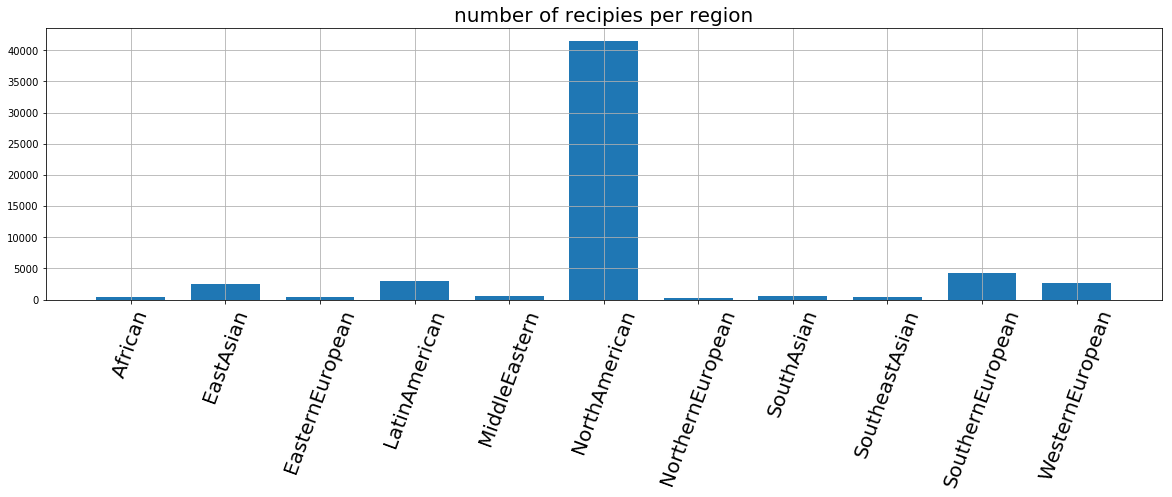

In [8]:
df_orig=df.copy()
region_count_orig=df_orig.groupby('Region').count()
barplot(ys=region_count_orig['Ingredients'],
        labels=region_count_orig.index,
        title='number of recipies per region')

In [9]:
#penalizing NorthAmerica
print(df.shape)

idx_namerica=df['Region']=='NorthAmerican'
df_namerica=df[idx_namerica]

idx_others=df['Region']!='NorthAmerican'
df_others=df[idx_others]


for region in df_others['Region'].unique():
    region_idx=df_others['Region']==region

    if(sum(region_idx)<1000):
        df_others=df_others.append([df_others[region_idx]]*5, ignore_index=True)

#print(df.shape)
#print(sum(idx_namerica)+sum(idx_others))

df_namerica=df_namerica.sample(4000)
df=df_namerica.append(df_others)
#print(df.shape)

(56498, 2)


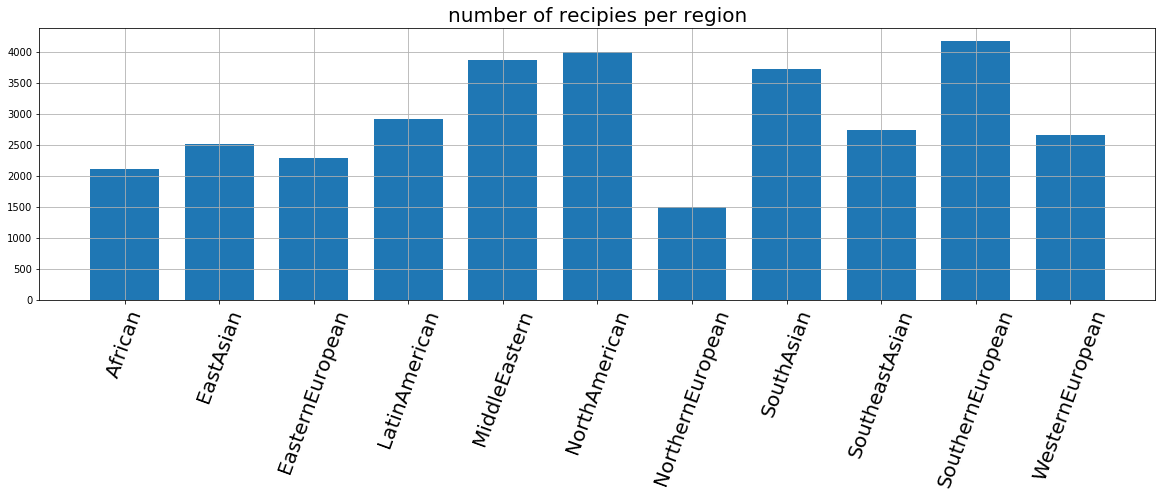

In [10]:
region_count=df.groupby('Region').count()

barplot(ys=region_count['Ingredients'], 
        labels=region_count.index, 
        title='number of recipies per region')

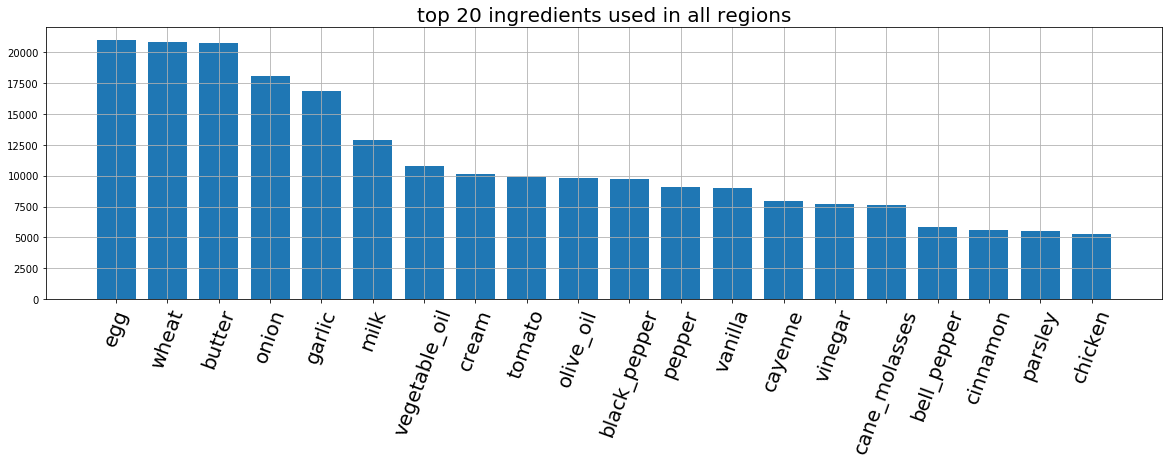

In [11]:
ingredients_per_region=[]

for row in raw_df:
    for ingredient in row[1].split():
        ingredients_per_region.append((row[0], ingredient))
    
df_ingredients_per_region=pd.DataFrame(ingredients_per_region, columns=['Region', 'Ingredient'])
df_ingredients_per_region.head()

top_ingredients=df_ingredients_per_region['Ingredient'].value_counts()[:20]
barplot(top_ingredients, top_ingredients.index, 'top 20 ingredients used in all regions')

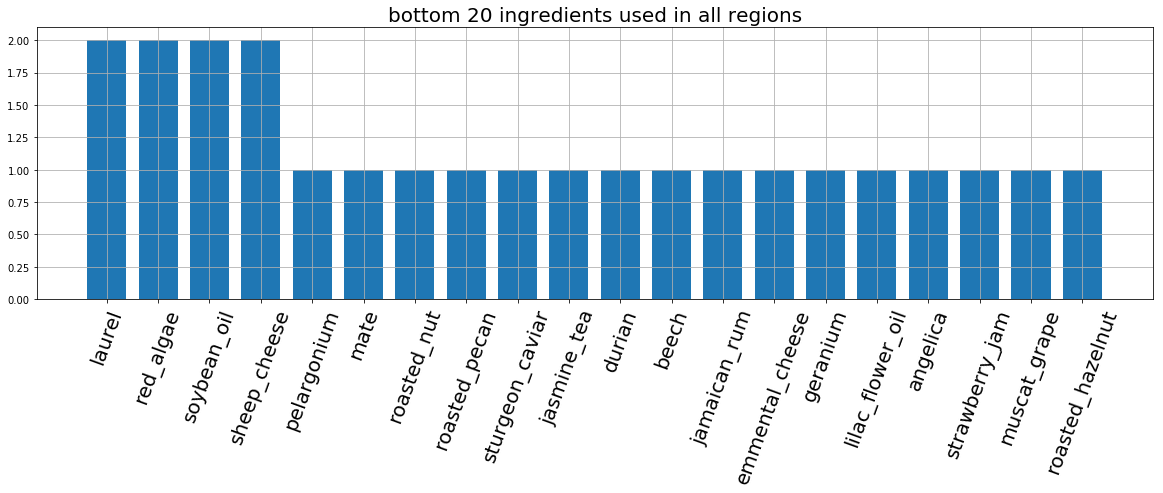

In [12]:
bottom_ingredients=df_ingredients_per_region['Ingredient'].value_counts()[-20:]
barplot(bottom_ingredients, bottom_ingredients.index, 'bottom 20 ingredients used in all regions')

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv_ingredients=CountVectorizer()
#X_ingredients=cv_ingredients.fit_transform(df['Ingredients'])
tv_ingredients=TfidfVectorizer()
X_ingredients=tv_ingredients.fit_transform(df['Ingredients'])

#ingredients_cv=cv_ingredients.build_analyzer()

In [14]:
from sklearn.preprocessing import LabelEncoder
l_encoder=LabelEncoder()
y_regions=l_encoder.fit_transform(df['Region'])
y_regions.shape

(32504,)

In [15]:
from sklearn.model_selection import train_test_split
X=X_ingredients.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y_regions, test_size=0.3, random_state=5)
#X_train.shape, y_train.shape#, df_region_nums.shape

In [16]:
from sklearn.linear_model import LogisticRegression

start=datetime.now()
print(start)
lr=LogisticRegression(random_state=100)
lr.fit(X_train, y_train)
print(datetime.now()-start)

2018-12-23 09:02:37.164267


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0:00:02.188727


In [17]:
#df_region_nums=df_region_nums==1
lr_predicted=lr.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Logistic Regression')
print(classification_report(y_test, lr_predicted, target_names=l_encoder.classes_))
print('Accuracy: ', accuracy_score(y_test, lr_predicted))

#precision: ratio of how many positive predictions are correct
#recall: ratio of how many positive predictions were missed
#f1: weighted harmonic mean of the precision and recall
#support: number of occurrences of each class in y_true.

                  precision    recall  f1-score   support

         African       0.65      0.53      0.58       614
       EastAsian       0.89      0.86      0.87       761
 EasternEuropean       0.56      0.56      0.56       701
   LatinAmerican       0.76      0.72      0.74       897
   MiddleEastern       0.53      0.54      0.54      1159
   NorthAmerican       0.48      0.52      0.50      1187
NorthernEuropean       0.62      0.55      0.58       473
      SouthAsian       0.75      0.85      0.80      1118
  SoutheastAsian       0.84      0.82      0.83       802
SouthernEuropean       0.64      0.72      0.68      1246
 WesternEuropean       0.42      0.34      0.38       794

       micro avg       0.64      0.64      0.64      9752
       macro avg       0.65      0.64      0.64      9752
    weighted avg       0.64      0.64      0.64      9752

Accuracy:  0.6449958982772764


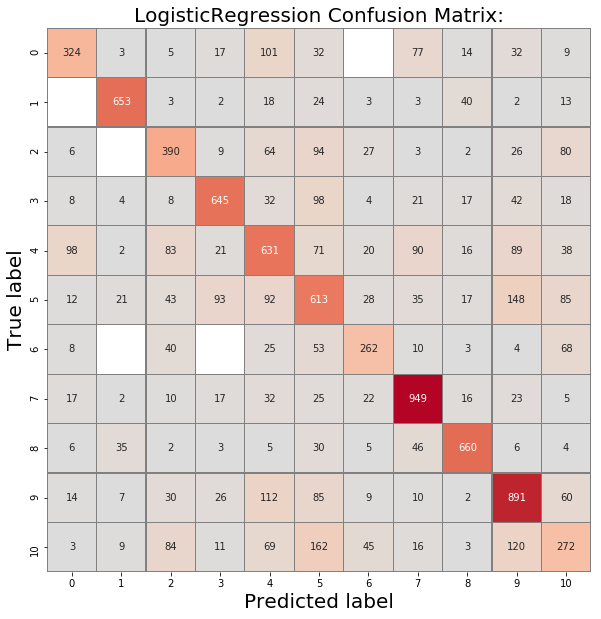

In [21]:
lr_cf=confusion_matrix(y_test, lr_predicted)
plot_confusion_matrix(lr_cf, 'LogisticRegression Confusion Matrix:')

In [22]:
#hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

start=datetime.now()

print(start)
estimator_benchm=[]
for num_est in [10, 20, 30, 50, 80, 100]:
    print('num_est: ', num_est)
    rnd_forest=RandomForestClassifier(n_estimators=num_est, random_state=100)
    rnd_forest.fit(X_train, y_train)
    rnd_f_predicted=rnd_forest.predict(X_test)
    
    benchm=(num_est, accuracy_score(y_test, rnd_f_predicted))
    estimator_benchm.append(benchm)
    print(benchm)

print(datetime.now()-start)

2018-12-23 09:02:40.084902
num_est:  10
(10, 0.8029122231337161)
num_est:  20
(20, 0.8135767022149303)
num_est:  30
(30, 0.8168580803937654)
num_est:  50
(50, 0.8200369155045119)
num_est:  80
(80, 0.8239335520918786)
num_est:  100
(100, 0.8252666119770303)
0:00:43.188521


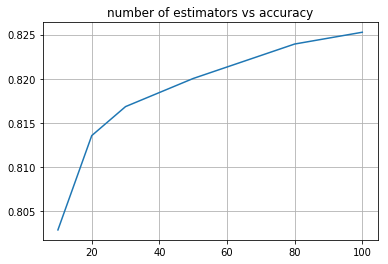

In [23]:
xs=[x[0] for x in estimator_benchm]
ys=[y[1] for y in estimator_benchm]

plt.title('number of estimators vs accuracy')
plt.grid()
plt.plot(xs, ys)

In [36]:
start=datetime.now()
print(start)

rnd_forest=RandomForestClassifier(n_estimators=80, random_state=100)
rnd_forest.fit(X_train, y_train)
rnd_f_predicted=rnd_forest.predict(X_test)

print(datetime.now()-start)

2018-12-23 09:04:58.328108
0:00:12.216553


In [37]:
print('Random Forest Classifier')
print(classification_report(y_test, rnd_f_predicted, target_names=l_encoder.classes_))
print('Accuracy: ', accuracy_score(y_test, rnd_f_predicted))

Random Forest Classifier
                  precision    recall  f1-score   support

         African       0.90      0.95      0.92       614
       EastAsian       0.91      0.92      0.92       761
 EasternEuropean       0.91      0.95      0.93       701
   LatinAmerican       0.81      0.75      0.78       897
   MiddleEastern       0.89      0.93      0.91      1159
   NorthAmerican       0.60      0.57      0.59      1187
NorthernEuropean       0.89      0.97      0.93       473
      SouthAsian       0.94      0.99      0.97      1118
  SoutheastAsian       0.97      0.99      0.98       802
SouthernEuropean       0.71      0.77      0.74      1246
 WesternEuropean       0.59      0.42      0.49       794

       micro avg       0.82      0.82      0.82      9752
       macro avg       0.83      0.84      0.83      9752
    weighted avg       0.82      0.82      0.82      9752

Accuracy:  0.8239335520918786


In [38]:
rnd_f_cf=confusion_matrix(y_test, rnd_f_predicted)

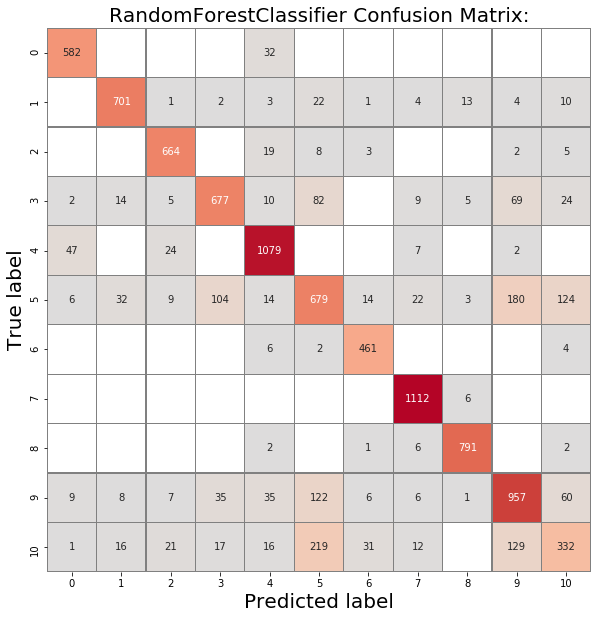

In [39]:
plot_confusion_matrix(rnd_f_cf, 'RandomForestClassifier Confusion Matrix:')

In [40]:
from sklearn.neural_network import MLPClassifier

n_net = MLPClassifier(
                    solver='adam',
                    activation='relu',
                    alpha=1e-5,
                    learning_rate='constant',
                    validation_fraction=0.1,
                    hidden_layer_sizes=(200, 3), 
                    random_state=100,
                    verbose=True) 
                    #max_iter=100)

In [41]:
start=datetime.now()
print(start)

n_net.fit(X_train, y_train)

print(datetime.now()-start)

2018-12-23 09:05:25.069097
Iteration 1, loss = 2.18395928
Iteration 2, loss = 1.84429008
Iteration 3, loss = 1.68173290
Iteration 4, loss = 1.58325911
Iteration 5, loss = 1.51158227
Iteration 6, loss = 1.45441865
Iteration 7, loss = 1.40509964
Iteration 8, loss = 1.36121481
Iteration 9, loss = 1.32063754
Iteration 10, loss = 1.28410094
Iteration 11, loss = 1.24850374
Iteration 12, loss = 1.21399487
Iteration 13, loss = 1.18069148
Iteration 14, loss = 1.14781640
Iteration 15, loss = 1.11569758
Iteration 16, loss = 1.08247572
Iteration 17, loss = 1.05155109
Iteration 18, loss = 1.02123184
Iteration 19, loss = 0.99129975
Iteration 20, loss = 0.96316638
Iteration 21, loss = 0.93629126
Iteration 22, loss = 0.90876297
Iteration 23, loss = 0.88352547
Iteration 24, loss = 0.85966437
Iteration 25, loss = 0.83646815
Iteration 26, loss = 0.81424681
Iteration 27, loss = 0.79213992
Iteration 28, loss = 0.77090604
Iteration 29, loss = 0.75179915
Iteration 30, loss = 0.73261912
Iteration 31, loss = 0

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [42]:
n_net_predicted=n_net.predict(X_test)

In [43]:
print('Neural Net Classifier')
print(classification_report(y_test, n_net_predicted, target_names=l_encoder.classes_))
print('Accuracy: ', accuracy_score(y_test, n_net_predicted))

Neural Net Classifier
                  precision    recall  f1-score   support

         African       0.95      0.84      0.89       614
       EastAsian       0.95      0.84      0.89       761
 EasternEuropean       0.83      0.90      0.86       701
   LatinAmerican       0.72      0.65      0.69       897
   MiddleEastern       0.82      0.98      0.89      1159
   NorthAmerican       0.48      0.46      0.47      1187
NorthernEuropean       0.80      0.94      0.86       473
      SouthAsian       0.94      0.98      0.96      1118
  SoutheastAsian       0.89      0.99      0.94       802
SouthernEuropean       0.72      0.66      0.69      1246
 WesternEuropean       0.46      0.39      0.42       794

       micro avg       0.77      0.77      0.77      9752
       macro avg       0.78      0.79      0.78      9752
    weighted avg       0.76      0.77      0.77      9752

Accuracy:  0.7713289581624282


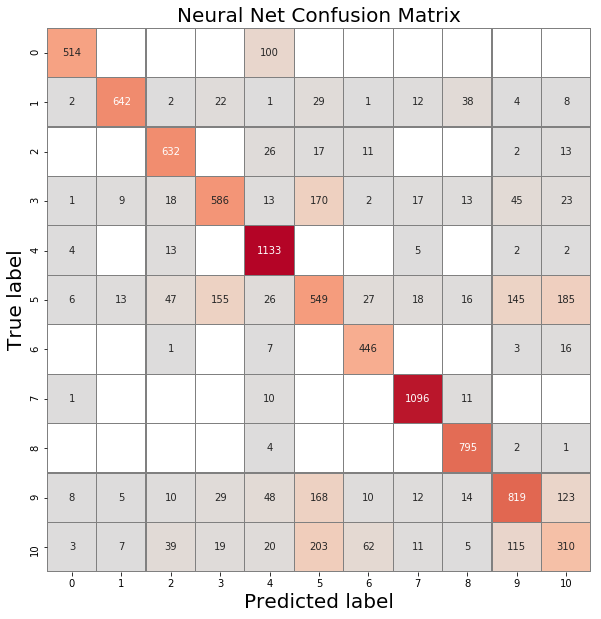

In [44]:
n_net_cf=confusion_matrix(y_test, n_net_predicted)
plot_confusion_matrix(n_net_cf, 'Neural Net Confusion Matrix')

In [45]:
recipies="""sesame_oil mushroom starch ginger bean garlic chicken sake shiitake cayenne scallion bell_pepper vegetable vegetable_oil beef_broth egg soy_sauce  
tomato vinegar celery_oil onion starch corn cayenne ginger shrimp honey garlic bell_pepper vegetable_oil egg     
vinegar mushroom onion beef starch sake tangerine orange_juice black_pepper carrot bell_pepper egg       
vinegar pork onion starch corn black_pepper carrot pineapple shiitake soy_sauce         
wheat starch vegetable_oil squid pineapple egg             
pork sesame_oil starch sake shiitake cayenne ginger scallion garlic bell_pepper vegetable_oil beef_broth soy_sauce      
kelp soybean beef radish soy_sauce black_pepper scallion            
wheat sesame_oil onion starch sake black_pepper soy_sauce cayenne ginger scallion garlic cod soybean vegetable_oil oyster    
pork sesame_oil onion starch shiitake cayenne ginger shrimp bean garlic vegetable_oil soy_sauce oyster pumpkin     
pork sesame_oil starch cayenne shiitake black_pepper scallion carrot nira garlic rice soy_sauce pumpkin      
vinegar starch sake cayenne soy_sauce black_pepper ginger scallion garlic chicken egg        
pork wheat mushroom squid black_pepper ginger carrot garlic vegetable_oil shrimp onion sake soy_sauce cayenne chinese_cabbage scallion vegetable mussel beef_broth
"""

recipies=[recipe.strip().split() for recipe in recipies.split('\n')]
len(recipies)

13

In [46]:
#predict region from ingredients
ft_names=tv_ingredients.get_feature_names()

recipe_vecs=[]
for recipe in recipies:
    ing_vec=np.zeros(X_train.shape[1])
    
    for ingredient in recipe:
        idx=ft_names.index(ingredient)
        ing_vec[idx]=1
    
    recipe_vecs.append(ing_vec)
        
ing_vec=np.array([ing_vec])
recipe_vecs=np.array(recipe_vecs)
print( X_train.shape, recipe_vecs.shape)

(22752, 367) (13, 367)


In [47]:
predicted_lr=lr.predict(recipe_vecs)
print('LogistReg_prediction: ')
for pred_num in predicted_lr:
    print(l_encoder.inverse_transform([pred_num]), pred_num)


rnd_f_predicted=rnd_forest.predict(recipe_vecs)
print('\n\nRND_Forest_prediction: ')
for pred_num in rnd_f_predicted:
  print(l_encoder.inverse_transform([pred_num]), pred_num)

n_net_predicted=n_net.predict(recipe_vecs)
print('\n\nNeural_Net_prediction: ')
for pred_num in n_net_predicted:
  print(l_encoder.inverse_transform([pred_num]), pred_num)


LogistReg_prediction: 
['EastAsian'] 1
['LatinAmerican'] 3
['MiddleEastern'] 4
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['SoutheastAsian'] 8
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['NorthAmerican'] 5


RND_Forest_prediction: 
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['NorthAmerican'] 5


Neural_Net_prediction: 
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['SouthernEuropean'] 9
